# Distribution of QSOs on the sky with respect to the target galaxies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#plotting things 
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 40

# update various fontsizes to match
params = {'figure.figsize': (20, 14),
          'legend.fontsize': 20,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 16,
          'xtick.minor.size': 13,
          'ytick.major.size': 16,
          'ytick.minor.size': 13}
plt.rcParams.update(params)

import astropy.units as u
from linetools.spectralline import AbsLine
from linetools.spectra import io as lsio
from linetools.isgm.abscomponent import AbsComponent
from linetools.spectra.xspectrum1d import XSpectrum1D
from linetools.lists.linelist import LineList
import glob

import seaborn as sns
pal = sns.color_palette("pastel")

import pickle

from pymccorrelation import pymccorrelation
import linmix

from scipy.stats import kendalltau
from seaborn.algorithms import bootstrap

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
#Bring in all the COS-Holes fit data and modifying
cosholes_df = pd.read_csv('/Users/samgarza/Documents/COS-Holes/notebooks/cosholes_df.csv')

In [4]:
#All the sums (including the upper limits)

sum_wups_ch = cosholes_df.loc[(cosholes_df['comp'] > 0)]
sum_wups_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,Rproj,Rvir,Rproj/Rvir,line,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim
0,NGC3489,J1101,0.002258,676.90,6.770,0.065,10.20,11.782755,-0.967,10.751189,110.019140,273.43553,0.402359,CIV,1548.204,0.002230,13.403000,0.099000,35.700,11.549,2.357,7.816,1,1
1,NGC4026,J1159,0.003286,985.10,8.255,0.125,10.43,11.964435,-1.767,13.641094,37.385240,314.35077,0.118928,CIV,1548.204,0.003300,13.697000,0.074000,80.715,17.306,-9.444,12.162,1,1
2,NGC4258,J1220,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.000000,69.778997,482.42196,0.144643,CIV,1550.781,0.001494,13.650000,0.050000,0.000,0.000,0.000,0.000,1,0
3,NGC4258,J1222,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.000000,130.305660,482.42196,0.270107,CIV,1550.781,0.001494,13.500000,0.050000,0.000,0.000,0.000,0.000,1,0
4,NGC4736,J1249,0.001027,307.80,6.830,0.123,10.62,12.154667,-0.061,0.000000,25.520224,363.76792,0.070155,CIV,1548.204,0.000000,14.311323,0.123487,0.000,0.000,0.000,0.000,2,1
8,NGC3414,J1051,0.004900,1469.80,8.400,0.071,10.79,12.377581,-1.047,150.546380,40.499140,431.64653,0.093825,CIV,1548.204,0.004420,13.990000,0.057000,32.780,5.621,6.646,3.813,1,1
9,NGC3627,J1123,0.002430,721.00,6.920,0.048,10.84,12.455645,0.536,117.031587,119.976000,458.29968,0.261785,CIV,1548.204,0.002750,14.012000,0.076000,85.000,17.787,-21.098,12.763,1,1
10,NGC1097,J0246,0.004240,1271.10,8.140,0.090,10.50,12.029020,0.766,24.205849,55.657239,330.32571,0.168492,CIV,1548.204,0.004220,14.211000,0.053000,54.100,7.973,18.210,5.687,1,1
11,NGC4564,J1235,0.003809,1141.90,7.940,0.145,10.40,11.938382,-1.988,0.000000,123.078500,308.12739,0.399440,CIV,1550.781,0.003809,13.380000,0.050000,0.000,0.000,0.000,0.000,1,0


In [5]:
angle = {'QSO': ['J1101', 'J1159', 'J1220', 'J1222', 'J1249', 'J1051', 'J1123', 'J0246', 'J1235'], 
        'angle': [331.26858, 22.685004, 208.53515, 206.81617, 41.789694, 0.88527137, 267.76004, 322.86973, 224.48967]}

angle_df = pd.DataFrame(data=angle)

In [6]:
#New larger df with Eagle values included 
cos_full = pd.merge(sum_wups_ch, angle_df, on="QSO")
cos_full

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,Rproj,Rvir,Rproj/Rvir,line,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim,angle
0,NGC3489,J1101,0.002258,676.90,6.770,0.065,10.20,11.782755,-0.967,10.751189,110.019140,273.43553,0.402359,CIV,1548.204,0.002230,13.403000,0.099000,35.700,11.549,2.357,7.816,1,1,331.268580
1,NGC4026,J1159,0.003286,985.10,8.255,0.125,10.43,11.964435,-1.767,13.641094,37.385240,314.35077,0.118928,CIV,1548.204,0.003300,13.697000,0.074000,80.715,17.306,-9.444,12.162,1,1,22.685004
2,NGC4258,J1220,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.000000,69.778997,482.42196,0.144643,CIV,1550.781,0.001494,13.650000,0.050000,0.000,0.000,0.000,0.000,1,0,208.535150
3,NGC4258,J1222,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.000000,130.305660,482.42196,0.270107,CIV,1550.781,0.001494,13.500000,0.050000,0.000,0.000,0.000,0.000,1,0,206.816170
4,NGC4736,J1249,0.001027,307.80,6.830,0.123,10.62,12.154667,-0.061,0.000000,25.520224,363.76792,0.070155,CIV,1548.204,0.000000,14.311323,0.123487,0.000,0.000,0.000,0.000,2,1,41.789694
5,NGC3414,J1051,0.004900,1469.80,8.400,0.071,10.79,12.377581,-1.047,150.546380,40.499140,431.64653,0.093825,CIV,1548.204,0.004420,13.990000,0.057000,32.780,5.621,6.646,3.813,1,1,0.885271
6,NGC3627,J1123,0.002430,721.00,6.920,0.048,10.84,12.455645,0.536,117.031587,119.976000,458.29968,0.261785,CIV,1548.204,0.002750,14.012000,0.076000,85.000,17.787,-21.098,12.763,1,1,267.760040
7,NGC1097,J0246,0.004240,1271.10,8.140,0.090,10.50,12.029020,0.766,24.205849,55.657239,330.32571,0.168492,CIV,1548.204,0.004220,14.211000,0.053000,54.100,7.973,18.210,5.687,1,1,322.869730
8,NGC4564,J1235,0.003809,1141.90,7.940,0.145,10.40,11.938382,-1.988,0.000000,123.078500,308.12739,0.399440,CIV,1550.781,0.003809,13.380000,0.050000,0.000,0.000,0.000,0.000,1,0,224.489670


In [7]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [8]:
from mycolorpy import colorlist as mcp
#For the MBH 
color1=mcp.gen_color(cmap="winter",n=5)
print(color1)

['#0000ff', '#0040df', '#0080bf', '#00c09f', '#00ff80']


In [9]:
r = cos_full['Rproj']
rr = cos_full['Rproj/Rvir']
theta = cos_full['angle']

In [10]:
mbh = np.array(cos_full["MBH"])
mbh

array([6.77 , 8.255, 7.577, 7.577, 6.83 , 8.4  , 6.92 , 8.14 , 7.94 ])

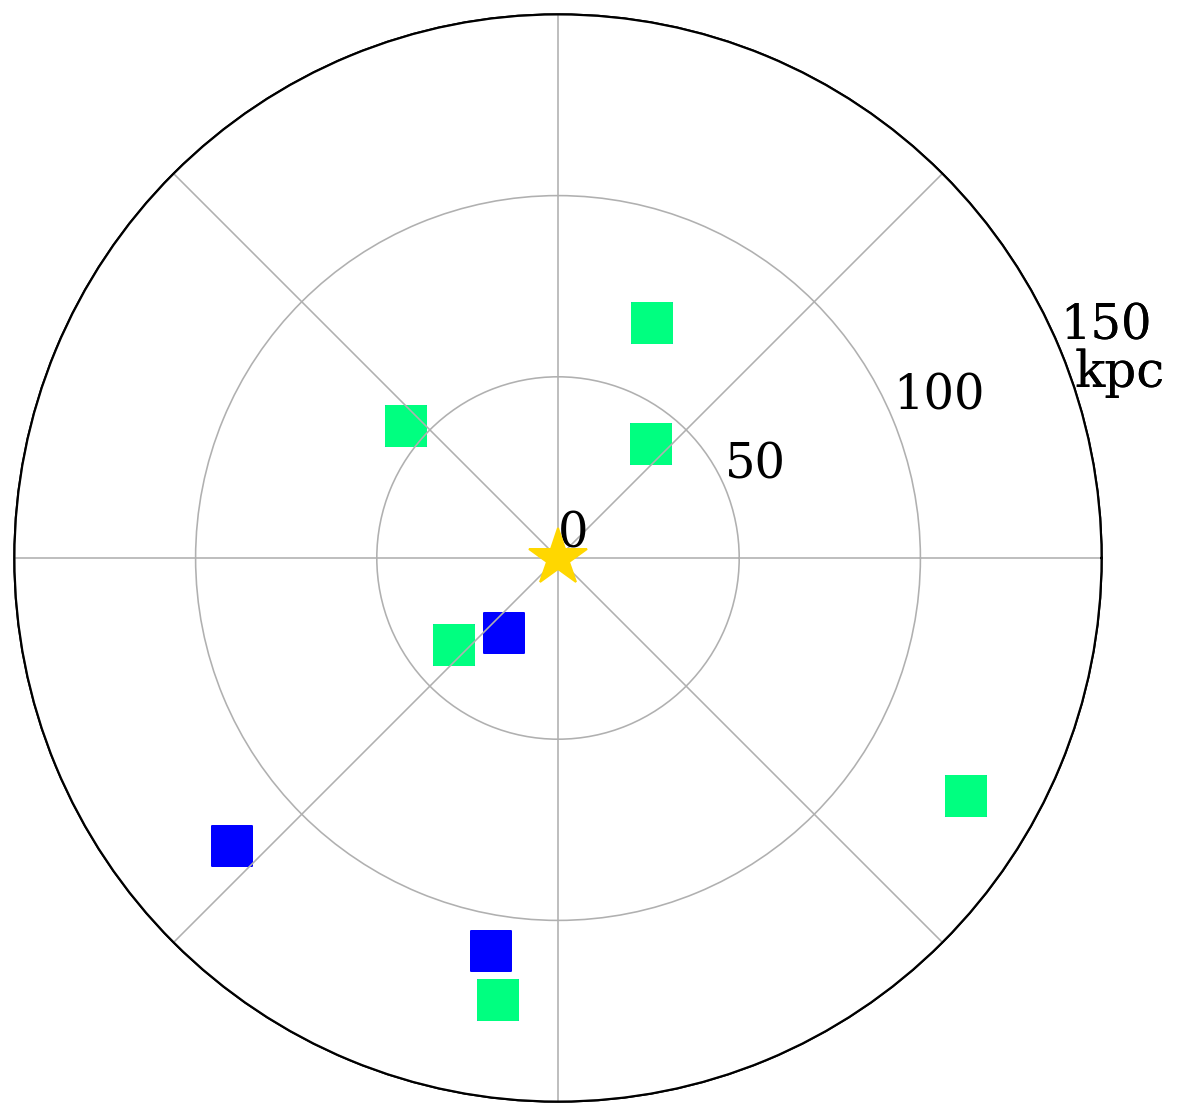

In [11]:
#creating masks to separate into high and low 
low_mask, high_mask = (mbh <= 7), (mbh > 7)

fig = plt.figure(figsize=(12,10))

for mask, colour in zip([low_mask, high_mask], ['#0000ff', '#00ff80']):
    ax = fig.add_subplot(projection='polar')
    ax.scatter(theta, r, c='#0000ff', marker="s", s=400)
    ax.scatter(theta[mask], r[mask], c=colour, marker="s", s=400)
    ax.plot(0, 0, c='gold', marker="*", markersize=30)

    ax.xaxis.set_ticklabels([])
    ax.set_yticks(np.arange(0,200, 50))
    plt.annotate('kpc', (0.32, 150), fontsize=25)
    #plt.annotate(r'0$^{\circ}$', (0,150), fontsize=25)
plt.savefig('Final_Figures/qso_dist_r.png')
plt.show()

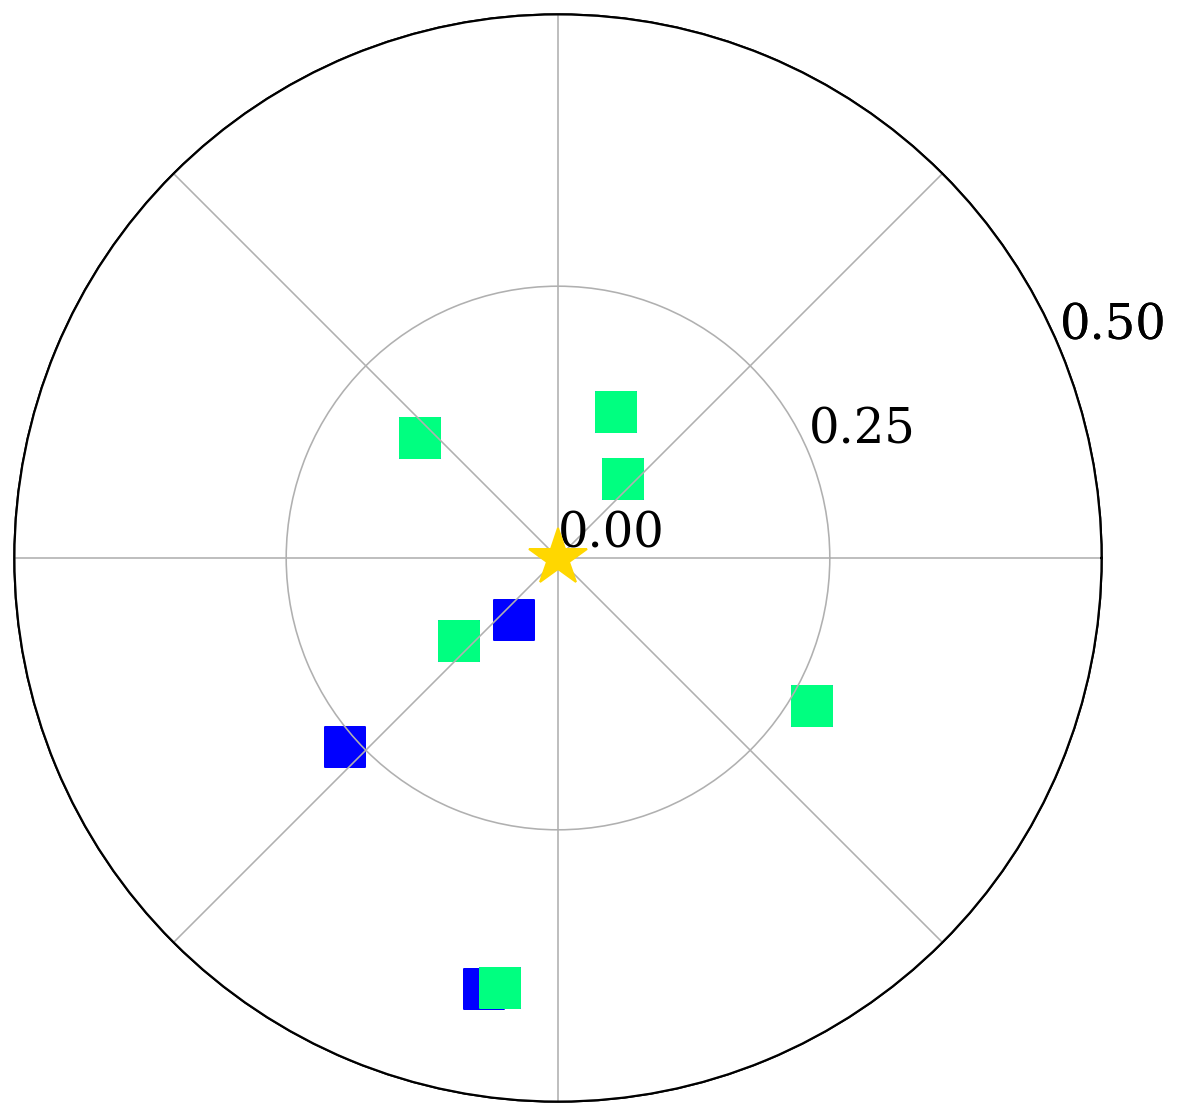

In [12]:
#creating masks to separate into high and low 
low_mask, high_mask = (mbh <= 7.0), (mbh > 7.0)

fig = plt.figure(figsize=(12,10))

for mask, colour in zip([low_mask, high_mask], ['#0000ff', '#00ff80']):
    ax = fig.add_subplot(projection='polar')
    ax.scatter(theta, rr, c='#0000ff', marker="s", s=400)
    ax.scatter(theta[mask], rr[mask], c=colour, marker="s", s=400)
    ax.plot(0, 0, c='gold', marker="*", markersize=30)

    ax.xaxis.set_ticklabels([])
    ax.set_yticks(np.arange(0,0.75, .25))
    #plt.annotate('kpc', (0.32, 150), fontsize=25)
    #plt.annotate(r'0$^{\circ}$', (0,0.5), fontsize=25)
plt.savefig('Final_Figures/qso_dist_rr.png')
plt.show()